In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/re_dataset.csv", encoding="latin-1")
df = df.drop(columns=['HS_Other','HS_Weak','HS_Moderate','HS_Strong'])
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0


In [5]:
df['Tweet'].iloc[4]

"USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'"

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 926.1+ KB


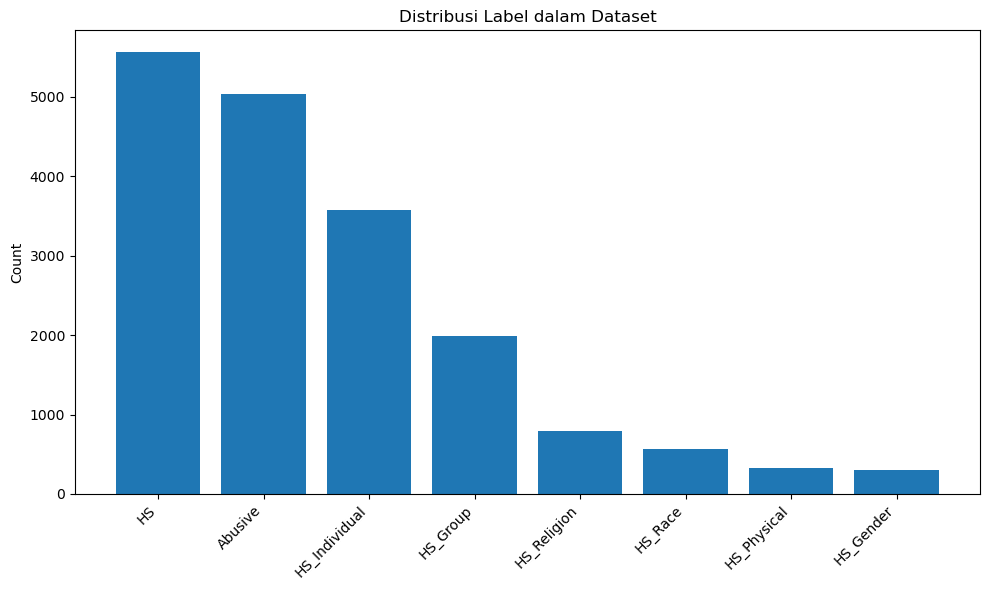

In [7]:
label_cols = [
    "HS", "Abusive", "HS_Individual", "HS_Group", "HS_Religion",
    "HS_Race", "HS_Physical", "HS_Gender"
]

freq = df[label_cols].sum().sort_values(ascending=False)
label_dist = (
    pd.DataFrame({
        "Count": df[label_cols].sum(),
        "Percentage": (df[label_cols].sum() / len(df) * 100).round(2)
    })
)

plt.figure(figsize=(10, 6))
plt.bar(label_dist.index, label_dist["Count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Distribusi Label dalam Dataset")
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss
from sklearn.svm import LinearSVC
from sklearn.multioutput import ClassifierChain
from xgboost import XGBClassifier
import re

In [9]:
alay_df = pd.read_csv("data\\new_kamusalay.csv")
alay_dict = dict(zip(alay_df["alay"], alay_df["normal"]))

In [10]:
def normalize_alay(text):
    words = text.split()
    return " ".join([alay_dict.get(w, w) for w in words])

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)   # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", " ", text)      # hapus angka/simbol
    text = re.sub(r"\s+", " ", text).strip()      # hapus spasi berlebih
    text = normalize_alay(text)                   # normalisasi pakai kamus CSV
    return text

contoh = "aamiinn pakcikdahtua tetap semangat"
print("Sebelum:", contoh)
print("Sesudah:", clean_text(contoh))
df["clean_text"] = df["Tweet"].apply(clean_text)

vectorizer = TfidfVectorizer(max_features=20000, analyzer="word", ngram_range=(1,1))

X = vectorizer.fit_transform(df["clean_text"])

Sebelum: aamiinn pakcikdahtua tetap semangat
Sesudah: amin pak cik sudah tua tetap semangat


In [11]:
label_cols = ["HS", "Abusive", "HS_Individual", "HS_Group",
              "HS_Religion", "HS_Race", "HS_Physical",
              "HS_Gender"]
y = df[label_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
base = LogisticRegression(class_weight="balanced")

cc = ClassifierChain(base, order=None, random_state=42)

print("Training Classifier Chain (LogReg)...")
cc.fit(X_train, y_train)
y_pred_cc = cc.predict(X_test)

print("\n🔹 Classification Report (per label):\n")
print(classification_report(y_test, y_pred_cc, target_names=label_cols, zero_division=0))

print("🔹 Hamming Loss:", hamming_loss(y_test, y_pred_cc))

Training Classifier Chain (LogReg)...

🔹 Classification Report (per label):

               precision    recall  f1-score   support

           HS       0.83      0.81      0.82      1118
      Abusive       0.83      0.81      0.82       988
HS_Individual       0.61      0.79      0.69       718
     HS_Group       0.82      0.32      0.45       400
  HS_Religion       0.62      0.63      0.62       164
      HS_Race       0.57      0.84      0.68       118
  HS_Physical       0.16      0.64      0.26        53
    HS_Gender       0.23      0.54      0.33        54

    micro avg       0.70      0.74      0.72      3613
    macro avg       0.58      0.67      0.58      3613
 weighted avg       0.75      0.74      0.72      3613
  samples avg       0.39      0.42      0.39      3613

🔹 Hamming Loss: 0.10032270311313592


In [13]:
idx_sample = np.random.choice(range(X_test.shape[0]), size=10, replace=False)

X_sample = X_test[idx_sample]
y_true = y_test.iloc[idx_sample]
y_pred = cc.predict(X_sample) 

for i, idx in enumerate(idx_sample):
    print(f"\n===== Sample {i+1} =====")
    print("Tweet:", df.iloc[y_test.index[idx]]["Tweet"])
    
    actual_dict = dict(zip(label_cols, y_true.iloc[i].astype(int).tolist()))
    predicted_dict = dict(zip(label_cols, y_pred[i].astype(int).tolist()))
    
    print("Actual   :", actual_dict)
    print("Predicted:", predicted_dict)


===== Sample 1 =====
Tweet: USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER
Actual   : {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
Predicted: {'HS': 1, 'Abusive': 1, 'HS_Individual': 1, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 1, 'HS_Gender': 0}

===== Sample 2 =====
Tweet: Ngambil referensi dari statust Fb....twitter....ig....dll\nditanyain no kontak alasan lupa....\nBangsaa tolol emang....makanya nggak maju maju.....'
Actual   : {'HS': 1, 'Abusive': 1, 'HS_Individual': 0, 'HS_Group': 1, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
Predicted: {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}

===== Sample 3 =====
Tweet: Wakil Gubernur DKI Jakarta USER sudah hadir dikantor DPP PKS dan duduk satu meja dengan Ketua Majelis Syu

In [20]:
# Tweet random di luar dataset
new_tweets = [
    "Selamat pagi semuanya, semoga harimu menyenangkan 😊",
    "Timnas Indonesia mainnya bagus banget semalam!",
    "Dasar sistem politik busuk, korupsi gak ada habisnya",
    "Kamu jelek banget, gak pantes hidup",
    "Mari kita dukung perdamaian dan persatuan bangsa",
    "Dasar tolol, goblok kalian semua, mata sipit anjing, islam kafir kontol!!"
]

# Preprocessing sama seperti sebelumnya
new_tweets_clean = [clean_text(t) for t in new_tweets]

# TF-IDF transform
X_new = vectorizer.transform(new_tweets_clean)

# Predict dengan model terbaik (misalnya CC dengan SVM)
y_new_pred = cc.predict(X_new)

# Tampilkan hasil
for i, tweet in enumerate(new_tweets):
    labels_pred = [label for label, val in zip(label_cols, y_new_pred[i]) if val == 1]
    print(f"\nTweet: {tweet}")
    print("Predicted labels:", labels_pred if labels_pred else "None")



Tweet: Selamat pagi semuanya, semoga harimu menyenangkan 😊
Predicted labels: None

Tweet: Timnas Indonesia mainnya bagus banget semalam!
Predicted labels: None

Tweet: Dasar sistem politik busuk, korupsi gak ada habisnya
Predicted labels: ['HS', 'Abusive', 'HS_Individual', 'HS_Physical']

Tweet: Kamu jelek banget, gak pantes hidup
Predicted labels: ['HS', 'Abusive', 'HS_Individual', 'HS_Physical']

Tweet: Mari kita dukung perdamaian dan persatuan bangsa
Predicted labels: None

Tweet: Dasar tolol, goblok kalian semua, mata sipit anjing, islam kafir kontol!!
Predicted labels: ['HS', 'Abusive', 'HS_Individual', 'HS_Religion', 'HS_Race', 'HS_Gender']


In [21]:
from lime.lime_text import LimeTextExplainer
import numpy as np

Teks: PELAJAR SMA KEC BILAH HILIR DEKLARASI ANTI HOAX &amp; PILKADA 2018 DAMAI
Aktual: {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}
Prediksi: {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0}


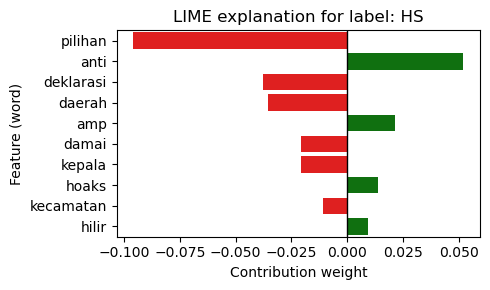

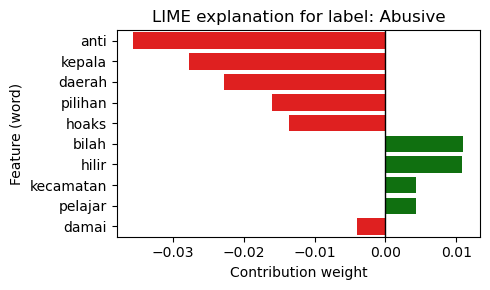

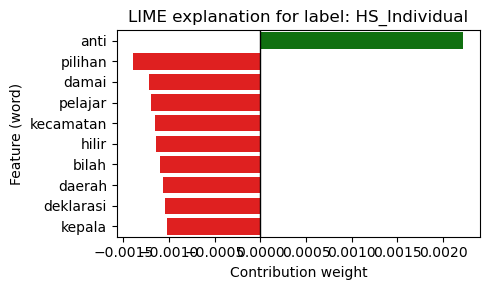

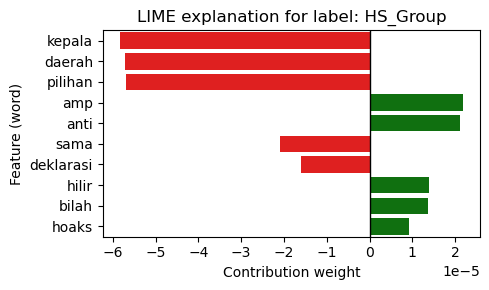

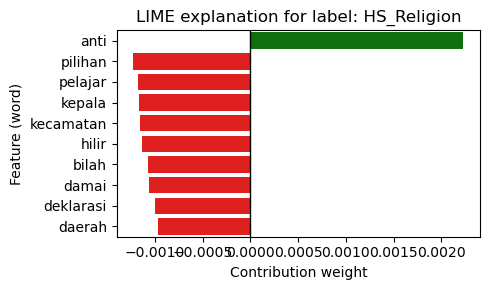

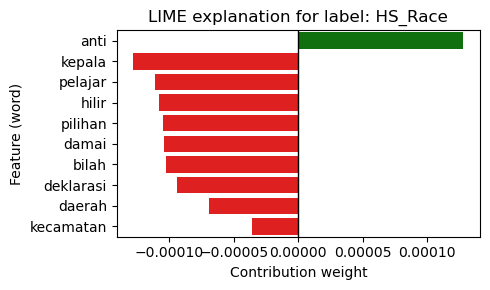

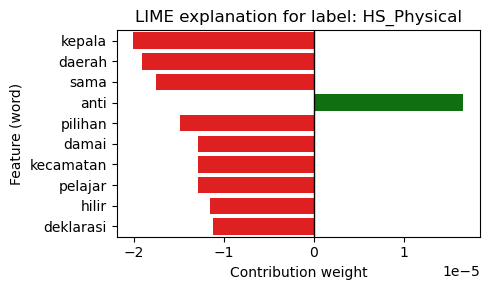

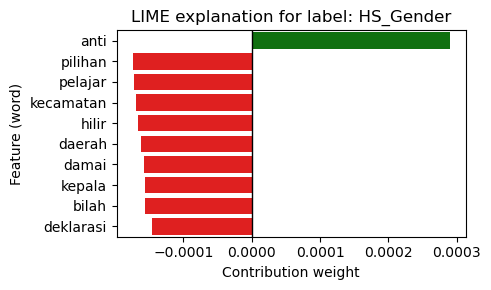

In [22]:
class_names = label_cols 
explainer = LimeTextExplainer(class_names=class_names)

idx = 23
text_instance = df.iloc[idx]["clean_text"]

def predict_proba(texts):
    X_vec = vectorizer.transform(texts)
    return cc.predict_proba(X_vec)

exp = explainer.explain_instance(
    text_instance,
    predict_proba,
    num_features=10,
    labels=list(range(len(label_cols)))
)

text_raw = df.iloc[idx]["Tweet"]

y_true = {k: int(v) for k, v in y_test.iloc[idx].to_dict().items()}

y_pred_arr = cc.predict(vectorizer.transform([text_instance]))[0]
y_pred = {label: int(val) for label, val in zip(label_cols, y_pred_arr)}

print("Teks:", text_raw)
print("Aktual:", y_true)
print("Prediksi:", y_pred)

for i, label in enumerate(label_cols):
    if i not in exp.local_exp:
        continue
    explanation = exp.as_list(label=i)
    df_exp = pd.DataFrame(explanation, columns=["feature", "weight"])
    df_exp["sign"] = df_exp["weight"].apply(lambda w: "positive" if w > 0 else "negative")

    plt.figure(figsize=(5, 3))
    sns.barplot(
        x="weight", y="feature", hue="sign", data=df_exp,
        dodge=False,
        palette={"positive": "green", "negative": "red"},
        legend=False
    )
    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"LIME explanation for label: {label}")
    plt.xlabel("Contribution weight")
    plt.ylabel("Feature (word)")
    plt.tight_layout()
    plt.show()

Teks: PELAJAR SMA KEC BILAH HILIR DEKLARASI ANTI HOAX &amp; PILKADA 2018 DAMAI
Aktual: {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0, 'HS_Other': 0}
Prediksi: {'HS': 0, 'Abusive': 0, 'HS_Individual': 0, 'HS_Group': 0, 'HS_Religion': 0, 'HS_Race': 0, 'HS_Physical': 0, 'HS_Gender': 0, 'HS_Other': 0}


c:\Users\santu\miniconda3\envs\myenv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
C:\Users\santu\AppData\Local\Temp\ipykernel_24496\597843733.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_instance,feature_names=vectorizer.get_feature_names_out())


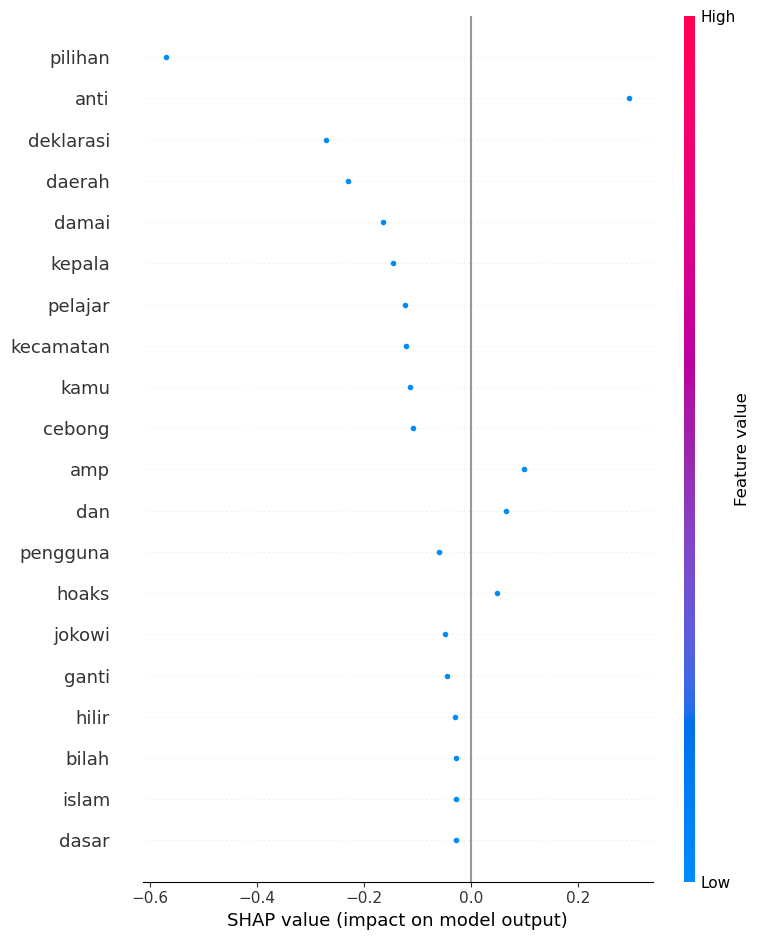

In [65]:
import shap
idx=23
text_instance=df.iloc[idx]["clean_text"]
text_raw=df.iloc[idx]["Tweet"]
y_true={k:int(v) for k,v in y_test.iloc[idx].to_dict().items()}
y_pred_arr=cc.predict(vectorizer.transform([text_instance]))[0]
y_pred={label:int(val) for label,val in zip(label_cols,y_pred_arr)}
print("Teks:",text_raw)
print("Aktual:",y_true)
print("Prediksi:",y_pred)
X_background=vectorizer.transform(df["clean_text"].sample(100,random_state=42)).toarray()
X_instance=vectorizer.transform([text_instance]).toarray()
explainer_shap=shap.LinearExplainer(cc.estimators_[0],X_background,feature_perturbation="interventional")
shap_values=explainer_shap.shap_values(X_instance)
shap.summary_plot(shap_values,X_instance,feature_names=vectorizer.get_feature_names_out())